In [57]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
from numba import njit, prange
from tqdm.notebook import tqdm
from time import time
from utils import metropolis, termalizar_S, metropolis2, h, calculate_dE

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

### Dos Impelementaciones de la $c(r)$

El primer término de la función de correlación es:
$$c(r) = \langle s_{i,j} s_{i, j+r}\rangle$$
Esta puede calcularse de manera explicita para todas las filas de manera independiente (en paralelo), sumando al final para obtener $c(r)$. De manera similar, el cálculo para cada valor de $r$ es independiente del resto, por lo que este barrido también puede paralelizarse. A continuación presentamos una implementación que aprovecha estas dos propiedades para acelerar el cálculo de $c(r)$:

In [58]:
@njit(parallel=True)
def cor_paralela(S: np.ndarray) -> np.ndarray:
    L = S.shape[0]
    cor_vec = np.zeros(L // 2)
    for r in prange(L//2):
        cor_filas = np.zeros(L)
        for i in prange(L):
            fila = S[i]
            fila_shift = np.roll(fila, r)
            cor_filas[i] = np.sum(fila * fila_shift)
        cor_vec[r] = np.sum(cor_filas)
    return cor_vec / (L**2)

Otra propiedad relevante para el cálculo de $c(r)$ es que esta es equivalente al cálculo de la convolución de las filas de $S$ consigo mismas, operación que puede implenentarse de manera óptima mediante el uso de la transformada rápida de Fourier (FFT). Si bien Numba no cuenta con soporte para la FFT, este algoritmo es suficientemente eficiente como para que esto no sea un problema. A continuación presentamos una implementación basada en la FFT:

In [59]:
def cor_fft(S):
    L = S.shape[0]
    S_hat = np.fft.fft(S, axis=1)
    cor = np.sum(np.fft.ifft(S_hat * S_hat.conj(), axis=1), axis=0)
    return np.real(cor[: L // 2]) / S.size

Para comparar ambas implementaciones podemos ejecutar el siguiente código que calcula $c(r)$ para `n_iteraciones` de `metropolis` y promedia el tiempo que tarda cada algoritmo para estimar la cantidad de iteraciones por segundo:

(la primera ejecución de `cor_paralela` puede demorar más por el tiempo de compilación de Numba, pero si se vuelve a ejecutar la celda sin re-definir las funciones de arriba se obtienen resultados consistentes)

In [70]:
L = 32
T = 2.7
beta = 1 / T
prob = np.exp(-beta * np.array([4, 8]))

S = np.ones((L, L), dtype=int)
S = termalizar_S(S, prob)
n_iteraciones = 10_000
start = time()
for _ in range(n_iteraciones):
    cor_paralela(S)
    S, _, _ = metropolis(S, prob)
print(f"Paralela (Numba): {(time() - start) / n_iteraciones:.3g} s / it")

S = np.ones((L, L), dtype=int)
S = termalizar_S(S, prob)
start = time()
for _ in range(n_iteraciones):
    cor_fft(S)
    S, _, _ = metropolis(S, prob)
print(f"FFT: {(time() - start) / n_iteraciones:.3g} s / it")

Paralela (Numba): 0.000265 s / it
FFT: 0.000165 s / it


Así puede verse que la implementación basada en la FFT demora $\sim 60\%$ menos por iteración que el algoritmo más explicito implementado en Numba.

Para validar que ambas implementaciones producen los mismos resultados, en la próxima celda se comparan los valores de $c(r)$ obtenidos a partir de ambos métodos. En el gráfico resultante puede observarse cómo ambas curvas se superponen a la perfección.

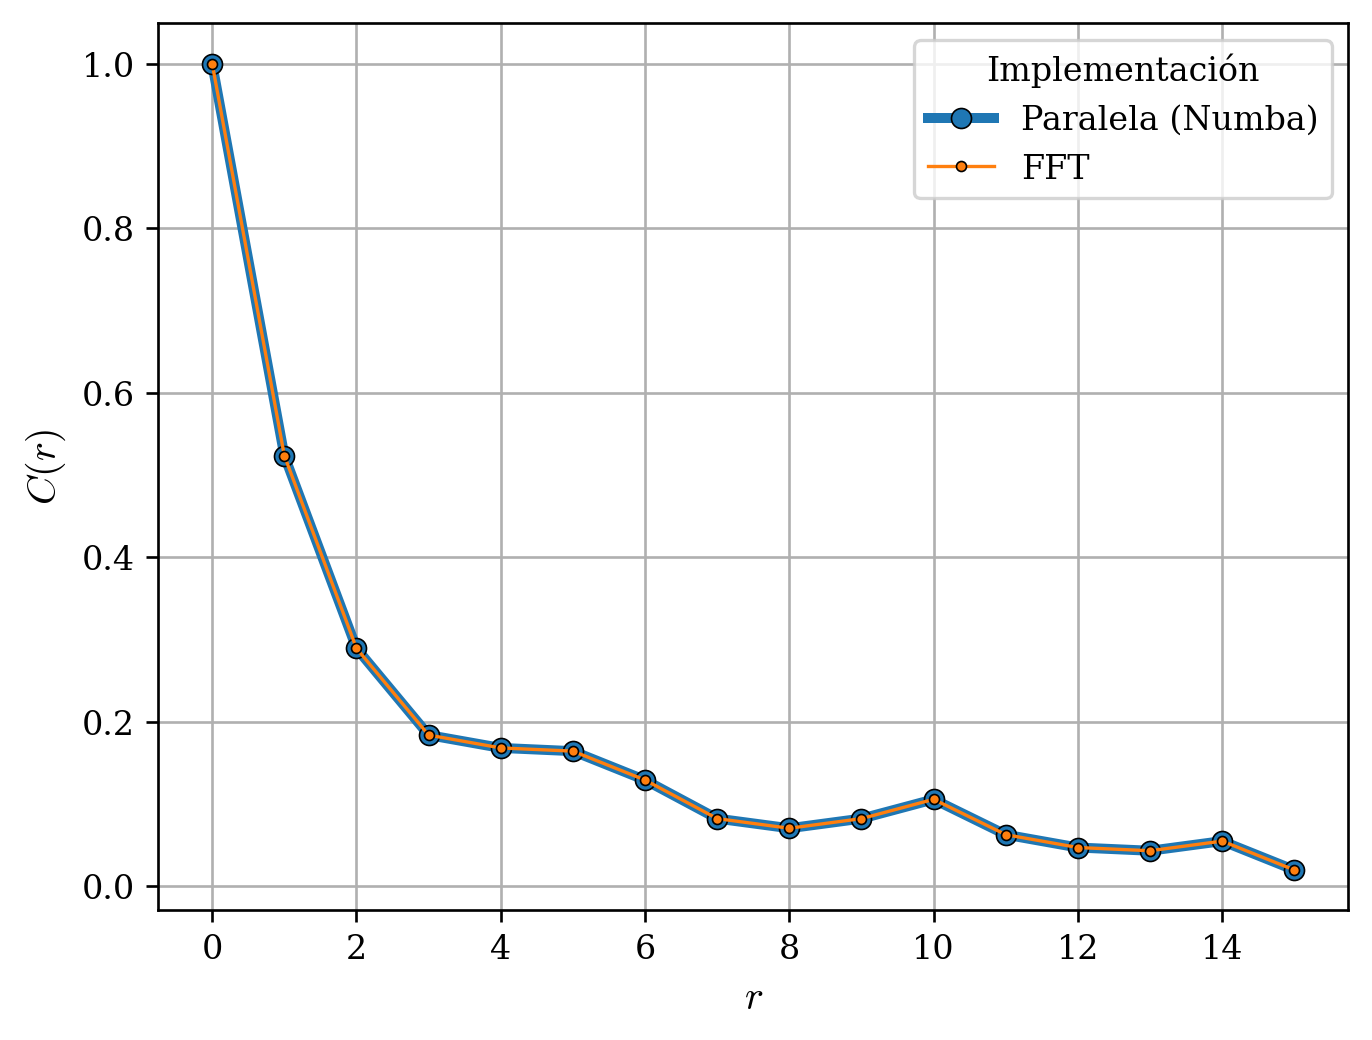

In [83]:
plt.plot(cor_paralela(S), "o-", mec="k", mew=0.5, lw=3, label="Paralela (Numba)")
plt.plot(cor_fft(S), ".-", mec="k", mew=0.5, lw=1, label="FFT")
plt.grid()
plt.legend(title="Implementación")
plt.xlabel("$r$")
plt.ylabel("$C(r)$")
plt.show()

Habiendo validado la equivalencia entre las implementaciones y la eficiencia superior del algoritmo basado en la FFT, procederemos aplicando este para definir la función `metropolis2`.

Dicho eso, dado que es dificil propagar los efectos de modificar un spin en el valor de $c(r)$ para toda la red, se propone calcular este valor antes y despues de dar los $L^2$ pasos del algoritmo `metropolis` y tomar su diferencia para calcular $dc$.

In [31]:

def metropolis2_fft(S: np.ndarray, prob: np.ndarray, cor_S: np.ndarray = None):
    # Aplica el algoritmo de Metropolis al estado S
    if cor_S is None:
        c_original = cor_fft(S)
    else:
        c_original = cor_S
    # La consigna dice que hay que aplicar el algoritmo de metrópolis por cada
    # sitio en la red, es decir, L cuadrado veces.
    S, dm, _ = metropolis(S, prob)
    dc = cor_fft(S) - c_original
    return S, dm, dc / S.size

## Ajustes a la Función de Correlación

Longitud de correlacion:


Temperaturas: 0it [00:00, ?it/s]

Termalizando:   0%|          | 0/500 [00:00<?, ?it/s]

Midiendo:   0%|          | 0/9999 [00:00<?, ?it/s]

T=1.5 => ξ=0.4018420584879747


Termalizando:   0%|          | 0/500 [00:00<?, ?it/s]

Midiendo:   0%|          | 0/9999 [00:00<?, ?it/s]

T=2.3 => ξ=4.724132910359498


Termalizando:   0%|          | 0/500 [00:00<?, ?it/s]

Midiendo:   0%|          | 0/9999 [00:00<?, ?it/s]

T=3 => ξ=1.1936331418883652


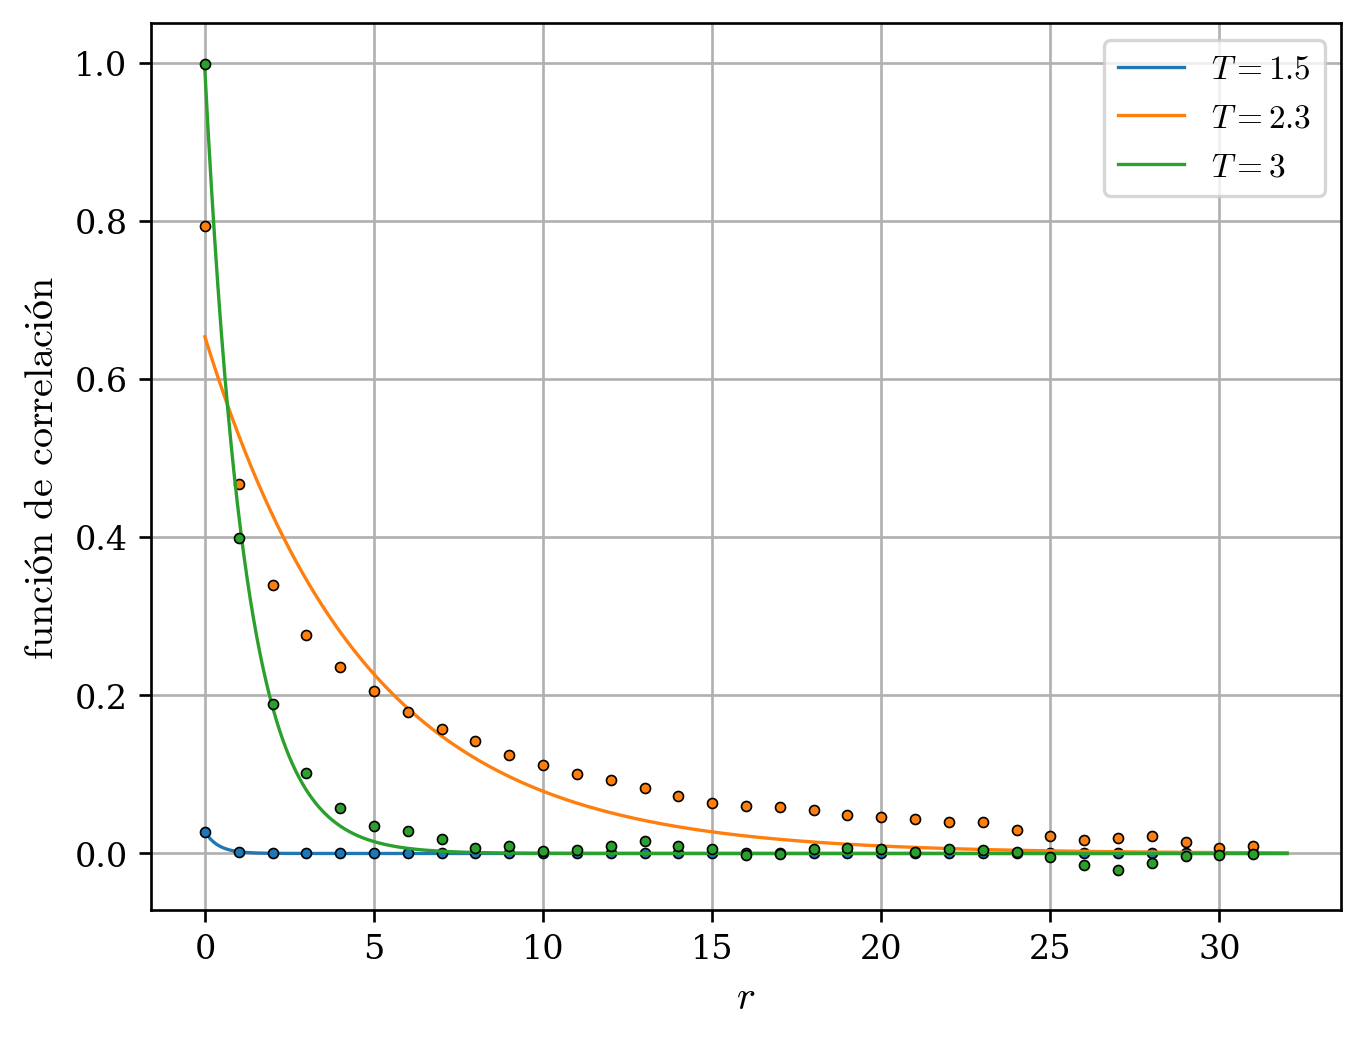

In [129]:
L = 64

nequilibrio = 500
npromedio = 10_000

l = L // 2  # numero de componentes del vector c
m = np.zeros(npromedio)  # magnetizacion en funcion del paso
c = np.zeros((l, npromedio))  # vector c en funcion del paso

r_vals = np.arange(l)  # dominio de la funcion de correlacion
r_dense = np.linspace(0, l, 1_000)

def fitcor(r, a, xi):  # funcion con la que vamos a ajustar
    return a * np.exp(-r / xi)


S = np.ones((L, L), dtype=int)
print("Longitud de correlacion:")

for i, T in tqdm(enumerate([1.5, 2.3, 3]), desc="Temperaturas"):
    beta = 1 / T
    prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])
    # Termalizamos con la funcion metropolis(S,prob), que es mas rapida
    for n in tqdm(range(nequilibrio), desc="Termalizando"):
        S, dm, de = metropolis(S, prob)
    m[0] = np.mean(S)
    c[:, 0] = cor_fft(S)
    for n in tqdm(range(1, npromedio), desc="Midiendo"):
        S, dm, dc = metropolis2_fft(S, prob, c[:, n - 1])
        m[n] = m[n - 1] + dm
        c[:, n] = c[:, n - 1] + dc

    mmedia = np.mean(abs(m))
    correlacion = np.mean(c, axis=1) - mmedia**2  # funcion de correlacion

    # Ajustamos:
    parametros, _ = curve_fit(fitcor, r_vals, correlacion)
    # (la funcion curve_fit devuelve el mejor valor de los parametros
    # y tambien la covarianza, que no vamos a usar)

    print(f"T={T} => ξ={parametros[1]}")

    plt.plot(
        r_dense, fitcor(r_dense, *parametros), "-", c=f"C{i}", lw=1, label=f"$T={T}$"
    )
    plt.plot(r_vals, correlacion, ".", c=f"C{i}", mec="k", mew=0.5)
plt.grid()
plt.xlabel("$r$")
plt.ylabel(r"$\text{función de correlación}$")
plt.legend()
plt.show()

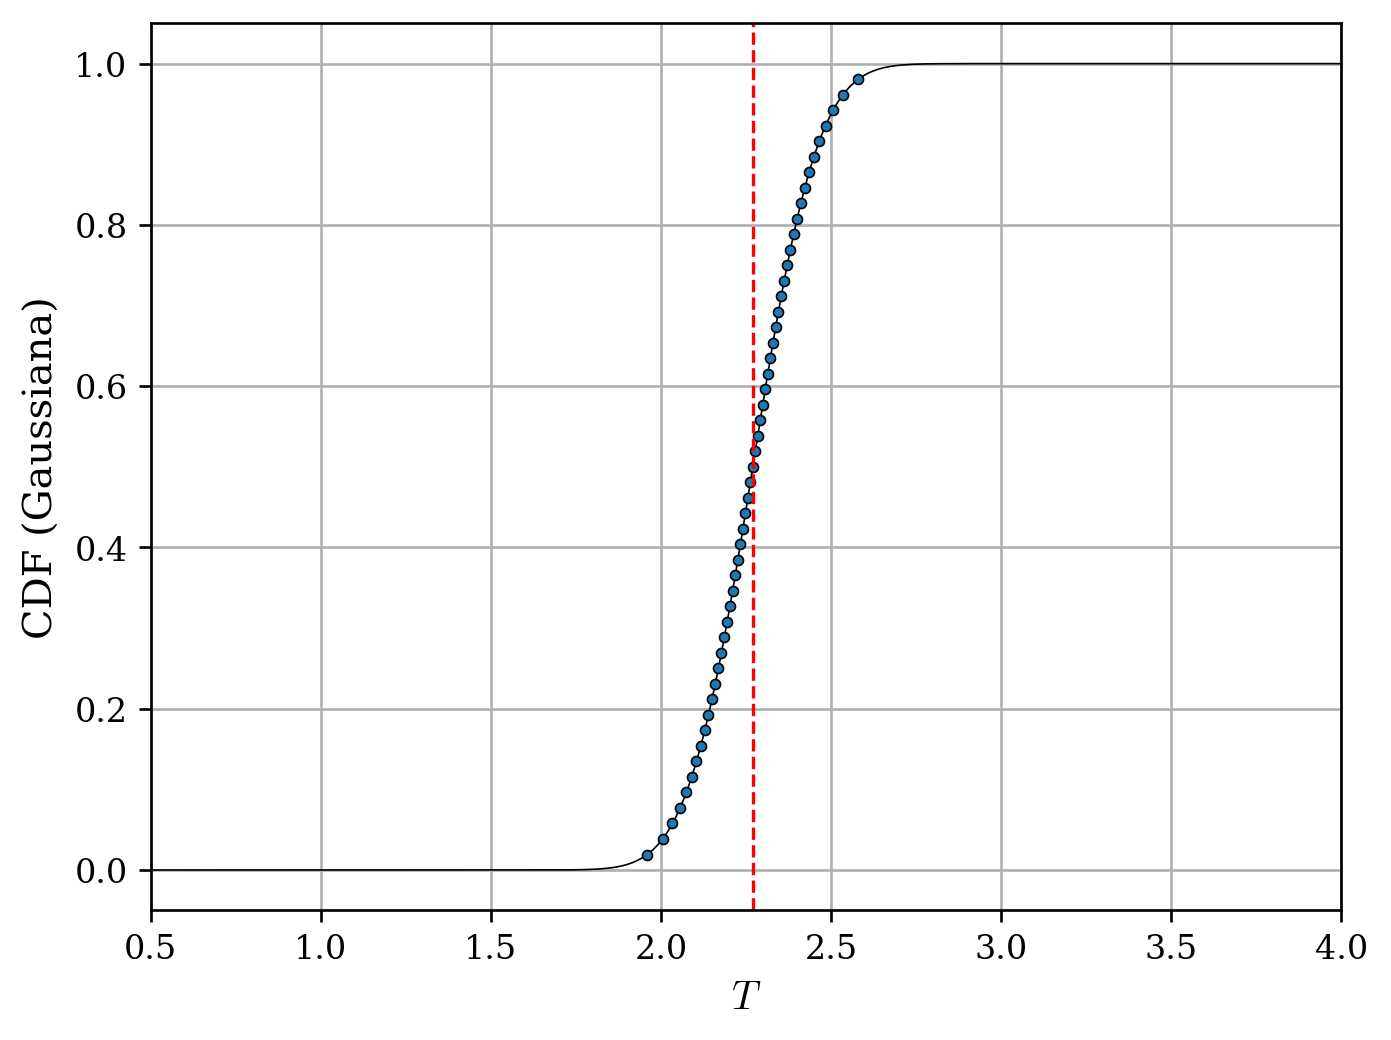

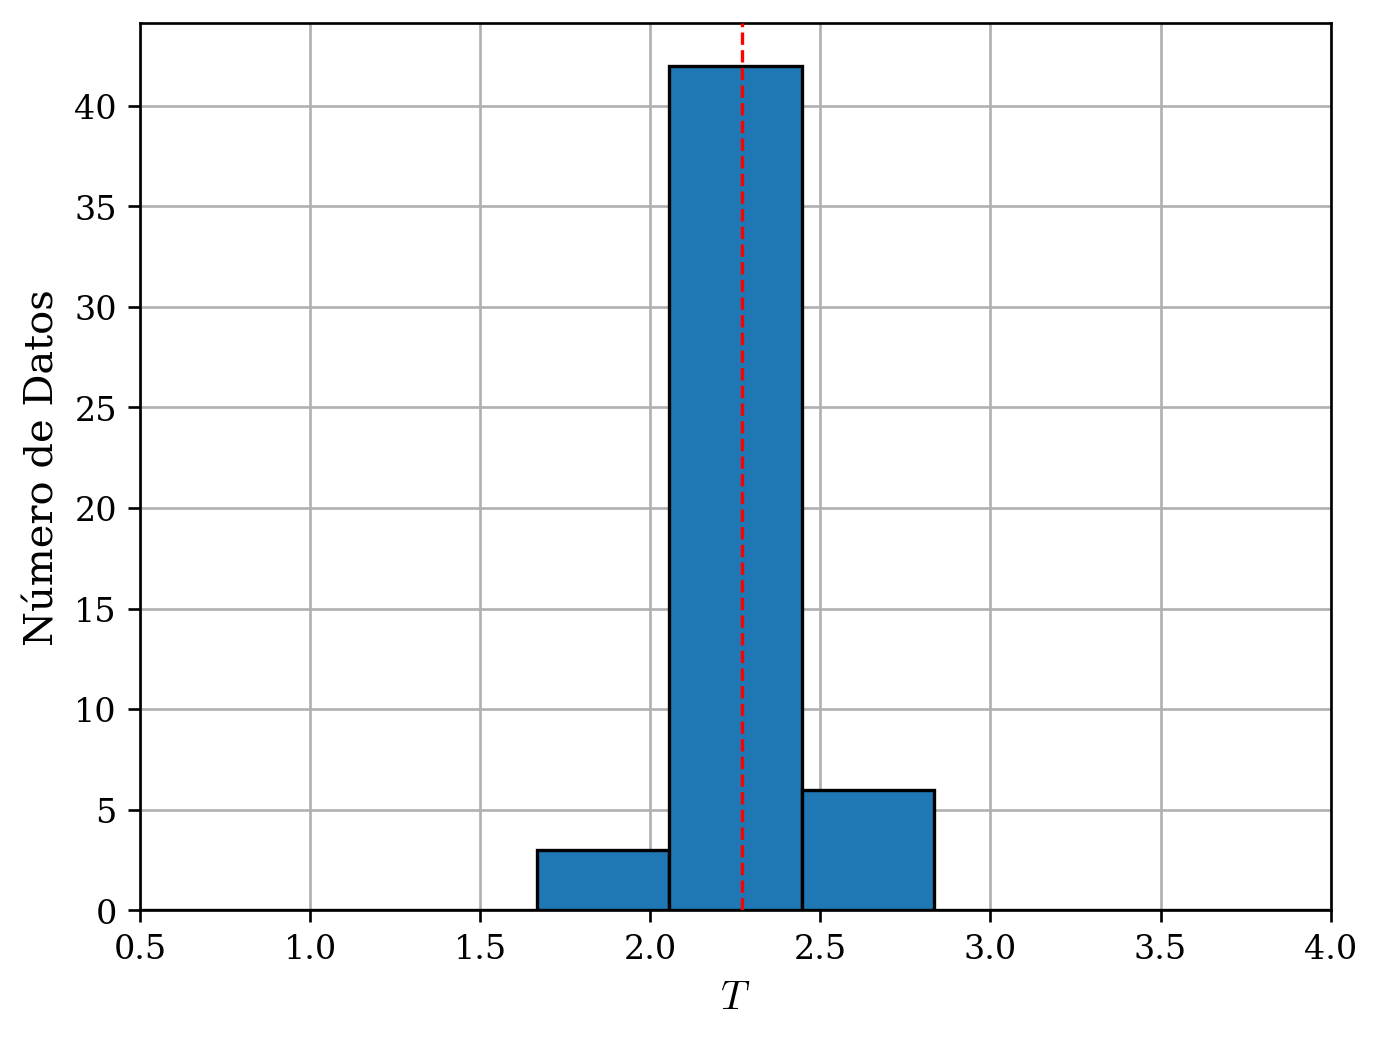

In [143]:
# Define the symmetry point
symmetry_point = 2.27
distribucion = stats.norm(loc=symmetry_point, scale=0.15)  # Gaussiana
numero_temps = 50 + 1
# Genero un array de valores equiespaciados entre 0 y 1 para samplear la ICDF
base_domain = np.linspace(1, 0, numero_temps+2)[1:-1]
plot_domain = np.linspace(0.5, 4, 1_000)
# Evaluo la ICDF en los valores generados
importance_sampled_domain = distribucion.isf(base_domain)

plt.plot(plot_domain, distribucion.cdf(plot_domain), "-", lw=0.5, c="k")
plt.plot(importance_sampled_domain, 1 - base_domain, ".", mec="k", mew=0.5)
plt.axvline(symmetry_point, color="r", ls="--", lw=1)
plt.grid()
plt.ylabel("CDF (Gaussiana)")
plt.xlabel("$T$")
plt.xlim(0.5, 4)
plt.show()

plt.hist(
    importance_sampled_domain,
    bins=np.linspace(0.5, 4, 10),
    edgecolor="k",
    zorder=10,
)
plt.axvline(symmetry_point, color="r", ls="--", lw=1, zorder=11)
plt.grid()
plt.ylabel("Número de Datos")
plt.xlabel("$T$")
plt.xlim(0.5, 4)
plt.show()


In [147]:
L = 64

nequilibrio = 500
npromedio = 10_000

l = L // 2  # numero de componentes del vector c
m = np.zeros(npromedio)  # magnetizacion en funcion del paso
c = np.zeros((l, npromedio))  # vector c en funcion del paso
xi_fit = np.zeros_like(importance_sampled_domain)
xi_err = np.zeros_like(importance_sampled_domain)

r_vals = np.arange(l)  # dominio de la funcion de correlacion
r_dense = np.linspace(0, l, 1_000)

S = np.ones((L, L), dtype=int)

for i, T in tqdm(enumerate(importance_sampled_domain), desc="Temperaturas", leave=False):
    beta = 1 / T
    prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])
    # Termalizamos con la funcion metropolis(S,prob), que es mas rapida
    # for n in tqdm(range(nequilibrio), desc="Termalizando", leave=False):
    for n in range(nequilibrio):
        S, dm, de = metropolis(S, prob)
    m[0] = np.mean(S)
    c[:, 0] = cor_fft(S)
    # for n in tqdm(range(1, npromedio), desc="Midiendo", leave=False):
    for n in range(1, npromedio):
        S, dm, dc = metropolis2_fft(S, prob, c[:, n - 1])
        m[n] = m[n - 1] + dm
        c[:, n] = c[:, n - 1] + dc
    mmedia = np.mean(abs(m))
    correlacion = np.mean(c, axis=1) - mmedia**2  # funcion de correlacion

    # Ajustamos:
    popt, pcov = curve_fit(fitcor, r_vals, correlacion)
    xi_fit[i] = popt[1]
    xi_err[i] = np.sqrt(pcov[1, 1])


Temperaturas: 0it [00:00, ?it/s]

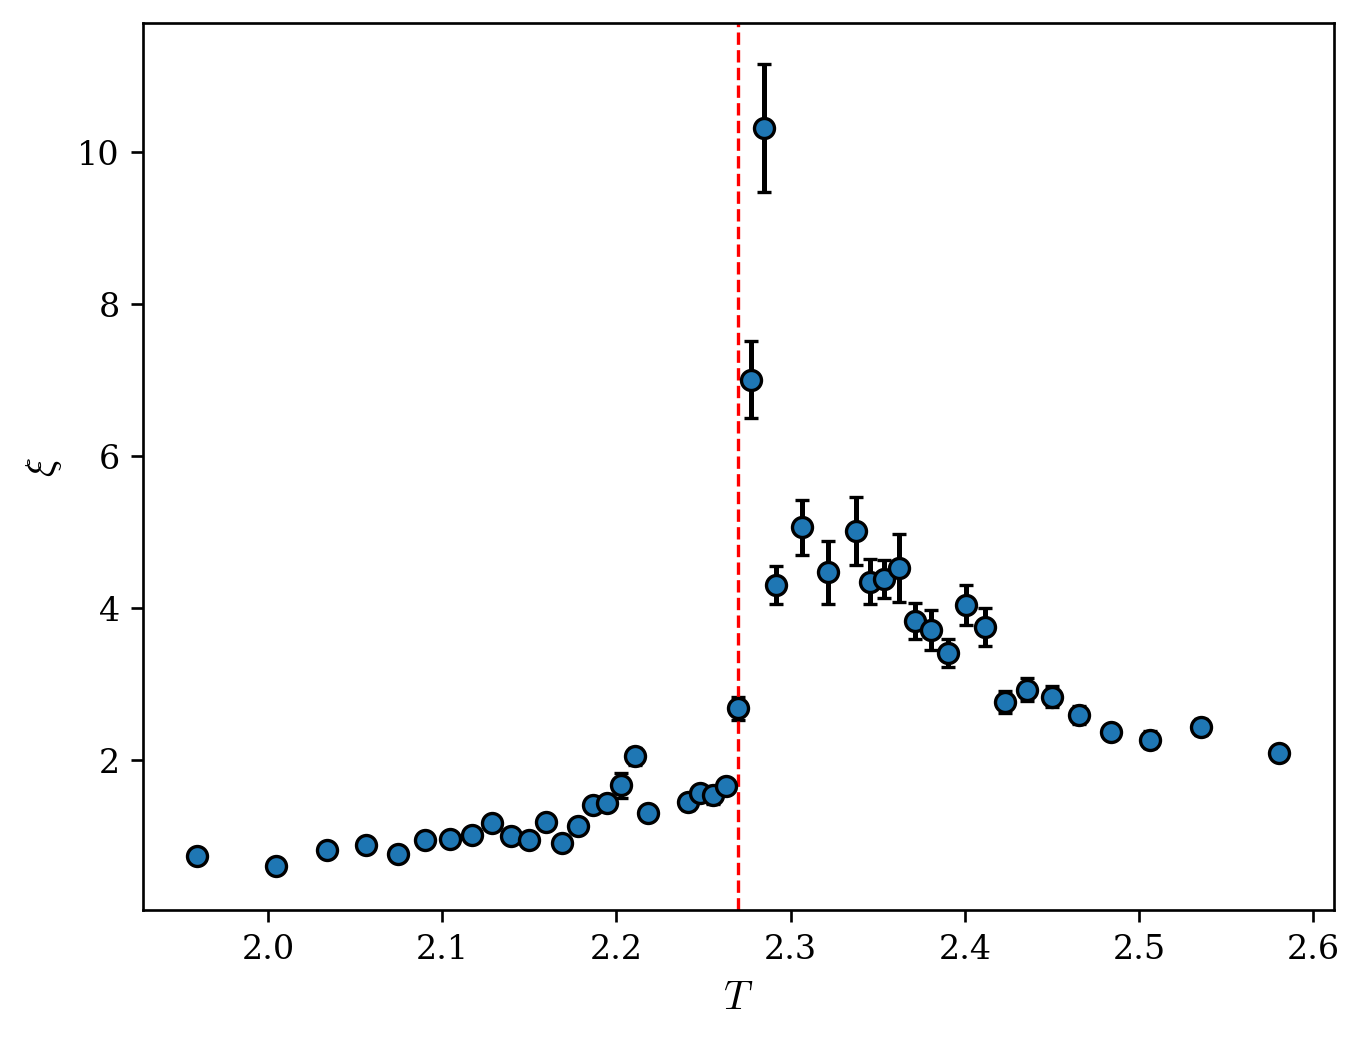

In [149]:
filtro_error_relativo = xi_err/xi_fit < 0.1
plt.errorbar(
    importance_sampled_domain[filtro_error_relativo],
    xi_fit[filtro_error_relativo],
    yerr=xi_err[filtro_error_relativo],
    fmt="o",
    markeredgecolor="k",
    ecolor="k",
    capsize=2,
)
plt.axvline(symmetry_point, color="r", ls="--", lw=1)
plt.ylabel(r"$\xi$")
plt.xlabel("$T$")
plt.show()